In [1]:
import vit_prisma
from vit_prisma.utils.data_utils.imagenet.imagenet_dict import IMAGENET_DICT
from vit_prisma.utils import prisma_utils

import numpy as np
import torch
from fancy_einsum import einsum
from collections import defaultdict

import plotly.graph_objs as go
import plotly.express as px

import matplotlib.colors as mcolors

from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

from IPython.display import display, HTML

import pandas as pd

from tqdm import tqdm

In [2]:
# Helper function (ignore)
def plot_image(image):
  plt.figure()
  plt.axis('off')
  plt.imshow(image.permute(1,2,0))

class ConvertTo3Channels:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

transform = transforms.Compose([
    ConvertTo3Channels(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [3]:
data_df = pd.read_csv('generated_images/data.csv')
data_df

,num_shapes,shape_0,color_0,position_0,filename,shape_1,color_1,position_1,shape_2,color_2,position_2,shape_3,color_3,position_3,shape_4,color_4,position_4
0,1,pentagon,red,BL,generated_images/image_1_shapes_0.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,pentagon,red,BR,generated_images/image_1_shapes_1.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,square,red,TR,generated_images/image_1_shapes_2.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,hexagon,black,M,generated_images/image_1_shapes_3.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,square,blue,M,generated_images/image_1_shapes_4.png,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,5,pentagon,blue,BR,generated_images/image_5_shapes_95.png,triangle,black,BL,hexagon,yellow,M,square,green,TL,circle,pink,TR
496,5,pentagon,pink,BR,generated_images/image_5_shapes_96.png,hexagon,yellow,BL,circle,red,TL,square,blue,M,triangle,green,TR
497,5,triangle,blue,M,generated_images/image_5_shapes_97.png,hexagon,pink,BR,circle,green,TL,pentagon,red,TR,square,yellow,BL
498,5,square,yellow,BL,generated_images/image_5_shapes_98.png,hexagon,red,BR,triangle,pink,TL,circle,blue,M,pentagon,black,TR


In [4]:
activations_df = pd.read_csv('clip_224/clip_mlp_activations.csv')
activations_df

,filename,mean_0_0,max_0_0,mean_0_1,max_0_1,mean_0_2,max_0_2,mean_0_3,max_0_3,mean_0_4,...,mean_23_1019,max_23_1019,mean_23_1020,max_23_1020,mean_23_1021,max_23_1021,mean_23_1022,max_23_1022,mean_23_1023,max_23_1023
0,generated_images/image_1_shapes_0.png,0.099164,0.257024,0.298203,0.333471,0.059541,0.090624,0.108643,0.212754,0.022055,...,-0.171294,0.034744,0.227626,0.437658,-0.130334,0.179163,-0.228286,0.008854,-0.119478,0.226579
1,generated_images/image_1_shapes_1.png,0.098868,0.236394,0.298659,0.333518,0.059578,0.093828,0.108109,0.198275,0.022334,...,-0.159002,0.128170,0.228707,0.454122,-0.121280,0.225495,-0.221970,0.040223,-0.119355,0.224534
2,generated_images/image_1_shapes_2.png,0.098371,0.198219,0.294899,0.335975,0.057270,0.078525,0.102543,0.166103,0.021096,...,-0.183971,0.081780,0.185437,0.404024,-0.099349,0.141499,-0.227266,-0.016253,-0.099449,0.229580
3,generated_images/image_1_shapes_3.png,0.105667,0.350031,0.310025,0.336265,0.058159,0.078626,0.111158,0.305242,0.023447,...,-0.175808,0.136730,0.170698,0.396673,-0.065466,0.173172,-0.210550,0.142581,-0.052900,0.315388
4,generated_images/image_1_shapes_4.png,0.102984,0.147678,0.304164,0.331992,0.063006,0.108819,0.106660,0.195209,0.021967,...,-0.175748,0.019588,0.204655,0.394590,-0.124101,0.192931,-0.233677,-0.016928,-0.109357,0.350109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,generated_images/image_5_shapes_95.png,0.102451,0.214196,0.264764,0.334364,0.047601,0.123497,0.108762,0.324152,0.021233,...,-0.142009,0.198176,0.214031,0.480671,-0.096051,0.227638,-0.217189,0.180153,-0.043028,0.357173
496,generated_images/image_5_shapes_96.png,0.099824,0.218822,0.254907,0.332797,0.048234,0.107941,0.103577,0.216401,0.023336,...,-0.147976,0.131034,0.200914,0.431632,-0.085056,0.267447,-0.210242,0.221128,-0.054774,0.284328
497,generated_images/image_5_shapes_97.png,0.099764,0.249264,0.256887,0.336022,0.047266,0.098838,0.109927,0.263641,0.019197,...,-0.151952,0.087928,0.201548,0.435799,-0.080965,0.278892,-0.212384,0.200994,-0.059827,0.318426
498,generated_images/image_5_shapes_98.png,0.101962,0.418774,0.262032,0.412612,0.047812,0.127314,0.110888,0.263006,0.021316,...,-0.147790,0.160468,0.201102,0.431684,-0.064188,0.318274,-0.208776,0.170633,-0.040669,0.427834


In [5]:
neuron_characteristics_df = pd.read_csv("clip_224\clip_mlp_neuron_characteristics_mean_top_30_last_10_layers.csv")
neuron_characteristics_df

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\vaash\AppData\Local\Temp\ipykernel_19920\1721254718.py:1: SyntaxWarning: invalid escape sequence '\c'
  neuron_characteristics_df = pd.read_csv("clip_224\clip_mlp_neuron_characteristics_mean_top_30_last_10_layers.csv")


,avg_num_shapes,avg_circle,avg_square,avg_triangle,avg_pentagon,avg_hexagon,avg_red,avg_green,avg_blue,avg_yellow,avg_pink,avg_black,avg_M,avg_TL,avg_TR,avg_BL,avg_BR,neuron_name,entropy
0,1.266667,0.166667,0.400000,0.033333,0.466667,0.200000,0.200000,0.200000,0.066667,0.100000,0.133333,0.566667,0.000000,0.133333,0.033333,0.300000,0.800000,mean_14_0,3.453314
1,1.033333,0.300000,0.033333,0.133333,0.500000,0.066667,0.133333,0.033333,0.033333,0.300000,0.266667,0.266667,0.133333,0.133333,0.000000,0.400000,0.366667,mean_14_1,3.542005
2,4.300000,0.900000,0.966667,0.933333,0.633333,0.866667,0.666667,0.666667,0.800000,0.566667,0.700000,0.900000,0.966667,0.933333,0.800000,0.733333,0.866667,mean_14_2,3.982080
3,1.066667,0.233333,0.033333,0.033333,0.433333,0.333333,0.133333,0.266667,0.166667,0.266667,0.233333,0.000000,0.500000,0.233333,0.100000,0.066667,0.166667,mean_14_3,3.617702
4,1.400000,0.566667,0.000000,0.733333,0.033333,0.066667,0.133333,0.333333,0.233333,0.233333,0.200000,0.266667,0.500000,0.100000,0.133333,0.333333,0.333333,mean_14_4,3.585032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,4.233333,0.800000,0.900000,0.833333,0.900000,0.800000,0.700000,0.433333,0.800000,0.933333,0.666667,0.700000,1.000000,0.800000,0.800000,0.833333,0.800000,mean_23_1019,3.980404
10236,1.966667,0.633333,0.333333,0.366667,0.400000,0.233333,0.133333,0.166667,0.200000,0.800000,0.433333,0.233333,0.433333,0.433333,0.400000,0.300000,0.400000,mean_23_1020,3.861107
10237,3.766667,0.700000,1.000000,0.700000,0.633333,0.733333,0.633333,0.500000,0.500000,0.433333,0.700000,1.000000,0.700000,0.600000,0.766667,0.766667,0.933333,mean_23_1021,3.962788
10238,4.300000,0.966667,0.833333,0.733333,0.900000,0.866667,0.666667,0.666667,0.766667,0.700000,0.666667,0.833333,0.900000,0.833333,0.833333,0.800000,0.933333,mean_23_1022,3.990011


In [6]:
def layer_num(neuron_name):
    return int(neuron_name.split('_')[1])

In [7]:
# filter neurons only in the last n layers
last_n_layers = 10
neuron_characteristics_df = neuron_characteristics_df[neuron_characteristics_df['neuron_name'].apply(lambda x: layer_num(x) >= 24 - last_n_layers)]
neuron_characteristics_df

,avg_num_shapes,avg_circle,avg_square,avg_triangle,avg_pentagon,avg_hexagon,avg_red,avg_green,avg_blue,avg_yellow,avg_pink,avg_black,avg_M,avg_TL,avg_TR,avg_BL,avg_BR,neuron_name,entropy
0,1.266667,0.166667,0.400000,0.033333,0.466667,0.200000,0.200000,0.200000,0.066667,0.100000,0.133333,0.566667,0.000000,0.133333,0.033333,0.300000,0.800000,mean_14_0,3.453314
1,1.033333,0.300000,0.033333,0.133333,0.500000,0.066667,0.133333,0.033333,0.033333,0.300000,0.266667,0.266667,0.133333,0.133333,0.000000,0.400000,0.366667,mean_14_1,3.542005
2,4.300000,0.900000,0.966667,0.933333,0.633333,0.866667,0.666667,0.666667,0.800000,0.566667,0.700000,0.900000,0.966667,0.933333,0.800000,0.733333,0.866667,mean_14_2,3.982080
3,1.066667,0.233333,0.033333,0.033333,0.433333,0.333333,0.133333,0.266667,0.166667,0.266667,0.233333,0.000000,0.500000,0.233333,0.100000,0.066667,0.166667,mean_14_3,3.617702
4,1.400000,0.566667,0.000000,0.733333,0.033333,0.066667,0.133333,0.333333,0.233333,0.233333,0.200000,0.266667,0.500000,0.100000,0.133333,0.333333,0.333333,mean_14_4,3.585032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,4.233333,0.800000,0.900000,0.833333,0.900000,0.800000,0.700000,0.433333,0.800000,0.933333,0.666667,0.700000,1.000000,0.800000,0.800000,0.833333,0.800000,mean_23_1019,3.980404
10236,1.966667,0.633333,0.333333,0.366667,0.400000,0.233333,0.133333,0.166667,0.200000,0.800000,0.433333,0.233333,0.433333,0.433333,0.400000,0.300000,0.400000,mean_23_1020,3.861107
10237,3.766667,0.700000,1.000000,0.700000,0.633333,0.733333,0.633333,0.500000,0.500000,0.433333,0.700000,1.000000,0.700000,0.600000,0.766667,0.766667,0.933333,mean_23_1021,3.962788
10238,4.300000,0.966667,0.833333,0.733333,0.900000,0.866667,0.666667,0.666667,0.766667,0.700000,0.666667,0.833333,0.900000,0.833333,0.833333,0.800000,0.933333,mean_23_1022,3.990011


In [8]:
NUM_LOW_ENTROPY_NEURONS = 100

In [9]:
low_entropy_neurons = neuron_characteristics_df.sort_values("entropy").head(NUM_LOW_ENTROPY_NEURONS)
low_entropy_neurons

,avg_num_shapes,avg_circle,avg_square,avg_triangle,avg_pentagon,avg_hexagon,avg_red,avg_green,avg_blue,avg_yellow,avg_pink,avg_black,avg_M,avg_TL,avg_TR,avg_BL,avg_BR,neuron_name,entropy
475,1.066667,0.566667,0.500000,0.000000,0.000000,0.000000,0.300000,0.133333,0.000000,0.233333,0.400000,0.000000,0.033333,0.300000,0.200000,0.266667,0.266667,mean_14_475,3.258612
3846,1.133333,0.900000,0.166667,0.000000,0.033333,0.033333,0.233333,0.133333,0.066667,0.233333,0.466667,0.000000,0.333333,0.400000,0.166667,0.166667,0.066667,mean_17_774,3.299331
991,1.000000,0.733333,0.100000,0.166667,0.000000,0.000000,0.166667,0.200000,0.166667,0.100000,0.366667,0.000000,0.466667,0.266667,0.133333,0.100000,0.033333,mean_14_991,3.313325
4021,1.066667,0.566667,0.233333,0.166667,0.100000,0.000000,0.133333,0.000000,0.000000,0.266667,0.666667,0.000000,0.200000,0.366667,0.100000,0.233333,0.166667,mean_17_949,3.319119
1828,1.266667,0.066667,0.433333,0.100000,0.333333,0.333333,0.233333,0.233333,0.233333,0.000000,0.133333,0.433333,0.000000,0.000000,0.000000,0.433333,0.833333,mean_15_804,3.319193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3039,1.100000,0.566667,0.233333,0.000000,0.300000,0.000000,0.166667,0.066667,0.100000,0.266667,0.500000,0.000000,0.066667,0.433333,0.133333,0.300000,0.166667,mean_16_991,3.428546
6295,1.000000,0.433333,0.100000,0.166667,0.166667,0.133333,0.033333,0.266667,0.200000,0.133333,0.333333,0.033333,0.733333,0.100000,0.000000,0.133333,0.033333,mean_20_151,3.428838
4687,1.133333,0.633333,0.066667,0.066667,0.300000,0.066667,0.200000,0.000000,0.066667,0.400000,0.466667,0.000000,0.366667,0.300000,0.200000,0.233333,0.033333,mean_18_591,3.429126
5834,1.133333,0.366667,0.100000,0.166667,0.400000,0.100000,0.066667,0.333333,0.266667,0.200000,0.200000,0.066667,0.833333,0.200000,0.000000,0.100000,0.000000,mean_19_714,3.429361


In [10]:
def get_feature_names(columns):
    feature_names = []
    for col in columns:
        if not col.startswith("avg_"):
            continue
        if "num_shapes" in col:
            continue
        feature_names.append(col)
    feature_names.sort()
    return feature_names

In [11]:
get_feature_names(low_entropy_neurons.columns)

['avg_BL',
 'avg_BR',
 'avg_M',
 'avg_TL',
 'avg_TR',
 'avg_black',
 'avg_blue',
 'avg_circle',
 'avg_green',
 'avg_hexagon',
 'avg_pentagon',
 'avg_pink',
 'avg_red',
 'avg_square',
 'avg_triangle',
 'avg_yellow']

In [12]:
def find_neurons_with_feature_pair(activations_df, feature1, feature2):
    # check if neuron has feature 1 + feature 2 > 0.9 * (sum of all features)

    feature_names = get_feature_names(activations_df.columns)

    imp_features = activations_df[feature1] + activations_df[feature2]
    total_features = activations_df[feature_names].sum(axis=1)

    activations_df['ratio'] = imp_features / total_features

    return activations_df

In [13]:
feature_names = get_feature_names(low_entropy_neurons.columns)
# feature_names = ['avg_black',
#  'avg_blue',
#  'avg_circle',
#  'avg_green',
#  'avg_hexagon',
#  'avg_pentagon',
#  'avg_pink',
#  'avg_red',
#  'avg_square',
#  'avg_triangle',
#  'avg_yellow']
pair_data = {}
for i in range(len(feature_names)):
    for j in range(i + 1, len(feature_names)):
        feature1 = feature_names[i]
        feature2 = feature_names[j]
        all_neurons = find_neurons_with_feature_pair(low_entropy_neurons, feature1, feature2)
        sum_ratios = all_neurons['ratio'].sum()
        top_neurons = all_neurons[all_neurons['ratio'] > 0.3]
        print(f"Feature pair: {feature1}, {feature2} - Neurons: {len(top_neurons)}, Sum of ratios: {sum_ratios:.2f}")

        pair_data[(feature1, feature2)] = {
            'all_neurons': top_neurons,
            'top_neurons': top_neurons,
            'sum_ratios': sum_ratios
        }

Feature pair: avg_BL, avg_BR - Neurons: 6, Sum of ratios: 11.80
Feature pair: avg_BL, avg_M - Neurons: 7, Sum of ratios: 18.86
Feature pair: avg_BL, avg_TL - Neurons: 0, Sum of ratios: 12.07
Feature pair: avg_BL, avg_TR - Neurons: 0, Sum of ratios: 8.55
Feature pair: avg_BL, avg_black - Neurons: 0, Sum of ratios: 9.05
Feature pair: avg_BL, avg_blue - Neurons: 0, Sum of ratios: 10.12
Feature pair: avg_BL, avg_circle - Neurons: 2, Sum of ratios: 19.37
Feature pair: avg_BL, avg_green - Neurons: 0, Sum of ratios: 11.70
Feature pair: avg_BL, avg_hexagon - Neurons: 0, Sum of ratios: 8.77
Feature pair: avg_BL, avg_pentagon - Neurons: 0, Sum of ratios: 12.60
Feature pair: avg_BL, avg_pink - Neurons: 0, Sum of ratios: 17.04
Feature pair: avg_BL, avg_red - Neurons: 0, Sum of ratios: 9.78
Feature pair: avg_BL, avg_square - Neurons: 0, Sum of ratios: 12.35
Feature pair: avg_BL, avg_triangle - Neurons: 0, Sum of ratios: 10.15
Feature pair: avg_BL, avg_yellow - Neurons: 0, Sum of ratios: 11.55
Featu

In [14]:
# Get top 10 feature pairs with the most neurons
top_pairs_neurons = sorted(pair_data.items(), key=lambda x: len(x[1]['top_neurons']), reverse=True)
for pair, data in top_pairs_neurons:
    # feature1, feature2 = pair
    feature1, feature2 = sorted(pair)
    feature1 = feature1.replace("avg_", "")
    feature2 = feature2.replace("avg_", "")
    top_neurons = data['top_neurons']
    sum_ratios = data['sum_ratios']
    print(f"Feature pair: {feature1}, {feature2} - Neurons: {len(top_neurons)}, Sum of ratios: {sum_ratios:.2f}")

Feature pair: M, circle - Neurons: 53, Sum of ratios: 26.27
Feature pair: M, pink - Neurons: 39, Sum of ratios: 23.94
Feature pair: M, green - Neurons: 34, Sum of ratios: 18.59
Feature pair: circle, pink - Neurons: 34, Sum of ratios: 24.45
Feature pair: M, pentagon - Neurons: 28, Sum of ratios: 19.50
Feature pair: M, blue - Neurons: 26, Sum of ratios: 17.02
Feature pair: M, triangle - Neurons: 20, Sum of ratios: 17.05
Feature pair: M, yellow - Neurons: 15, Sum of ratios: 18.44
Feature pair: circle, square - Neurons: 11, Sum of ratios: 19.75
Feature pair: BR, black - Neurons: 9, Sum of ratios: 8.88
Feature pair: BR, square - Neurons: 9, Sum of ratios: 12.18
Feature pair: M, TL - Neurons: 9, Sum of ratios: 18.97
Feature pair: TL, circle - Neurons: 9, Sum of ratios: 19.48
Feature pair: BR, pentagon - Neurons: 8, Sum of ratios: 12.43
Feature pair: BL, M - Neurons: 7, Sum of ratios: 18.86
Feature pair: M, hexagon - Neurons: 7, Sum of ratios: 15.67
Feature pair: BL, BR - Neurons: 6, Sum of r

In [15]:
# Get top 10 feature pairs with the highest sum of ratios
top_pairs_ratios = sorted(pair_data.items(), key=lambda x: x[1]['sum_ratios'], reverse=True)
for pair, data in top_pairs_ratios:
    # feature1, feature2 = pair
    feature1, feature2 = sorted(pair)
    feature1 = feature1.replace("avg_", "")
    feature2 = feature2.replace("avg_", "")
    top_neurons = data['top_neurons']
    sum_ratios = data['sum_ratios']
    print(f"Feature pair: {feature1}, {feature2} - Neurons: {len(top_neurons)}, Sum of ratios: {sum_ratios:.2f}")

Feature pair: M, circle - Neurons: 53, Sum of ratios: 26.27
Feature pair: circle, pink - Neurons: 34, Sum of ratios: 24.45
Feature pair: M, pink - Neurons: 39, Sum of ratios: 23.94
Feature pair: circle, pentagon - Neurons: 1, Sum of ratios: 20.01
Feature pair: circle, square - Neurons: 11, Sum of ratios: 19.75
Feature pair: M, pentagon - Neurons: 28, Sum of ratios: 19.50
Feature pair: TL, circle - Neurons: 9, Sum of ratios: 19.48
Feature pair: BL, circle - Neurons: 2, Sum of ratios: 19.37
Feature pair: M, square - Neurons: 4, Sum of ratios: 19.24
Feature pair: BR, circle - Neurons: 1, Sum of ratios: 19.20
Feature pair: circle, green - Neurons: 2, Sum of ratios: 19.10
Feature pair: M, TL - Neurons: 9, Sum of ratios: 18.97
Feature pair: circle, yellow - Neurons: 3, Sum of ratios: 18.95
Feature pair: BL, M - Neurons: 7, Sum of ratios: 18.86
Feature pair: BR, M - Neurons: 1, Sum of ratios: 18.69
Feature pair: M, green - Neurons: 34, Sum of ratios: 18.59
Feature pair: M, yellow - Neurons: 1

In [16]:
# Save the sum_ratios and neuron counts with the feature pairs to a CSV file
pair_ratios_info = []
for pair, data in top_pairs_ratios:
    feature1, feature2 = sorted(pair)
    feature1 = feature1.replace("avg_", "")
    feature2 = feature2.replace("avg_", "")
    sum_ratios = data['sum_ratios']
    neuron_count = len(data['top_neurons'])
    pair_ratios_info.append({
        'feature1': feature1,
        'feature2': feature2,
        'sum_ratios': sum_ratios,
        'neuron_count': neuron_count
    })
pair_ratios_df = pd.DataFrame(pair_ratios_info)
pair_ratios_df

,feature1,feature2,sum_ratios,neuron_count
0,M,circle,26.265038,53
1,circle,pink,24.447719,34
2,M,pink,23.936011,39
3,circle,pentagon,20.007878,1
4,circle,square,19.751926,11
...,...,...,...,...
115,hexagon,red,6.584993,0
116,TR,red,6.364951,0
117,black,hexagon,5.854793,0
118,TR,black,5.634751,0


In [17]:
pair_ratios_df.to_csv(f"feature_pairs_ratios_{NUM_LOW_ENTROPY_NEURONS}.csv", index=False)

In [18]:
def get_top_features(neuron_characteristics_df, neuron_name, top_k=3):
    neuron_row = neuron_characteristics_df[neuron_characteristics_df['neuron_name'] == neuron_name].iloc[0]
    neuron_key_values = [(key, neuron_row[key]) for key in neuron_row.keys() if key not in ['neuron_name', 'entropy', 'avg_num_shapes']]
    # neuron_key_values = [(key, neuron_row[key]) for key in neuron_row.keys() if key not in ['neuron_name', 'entropy', 'avg_num_shapes', 'num_top_features_close']]
    neuron_key_values = sorted(neuron_key_values, key=lambda x: x[1], reverse=True)
    neuron_key_values = [(x[0].replace("avg_", ""), x[1]) for x in neuron_key_values]
    return neuron_key_values[:top_k]

get_top_features(low_entropy_neurons, 'mean_14_475', top_k=5)

[('circle', np.float64(0.5666666666666667)),
 ('square', np.float64(0.5)),
 ('pink', np.float64(0.4)),
 ('red', np.float64(0.3)),
 ('TL', np.float64(0.3))]

mean_17_774
[('circle', np.float64(0.9)), ('pink', np.float64(0.4666666666666667)), ('TL', np.float64(0.4)), ('M', np.float64(0.3333333333333333)), ('red', np.float64(0.2333333333333333))]
Neuron: mean_17_774


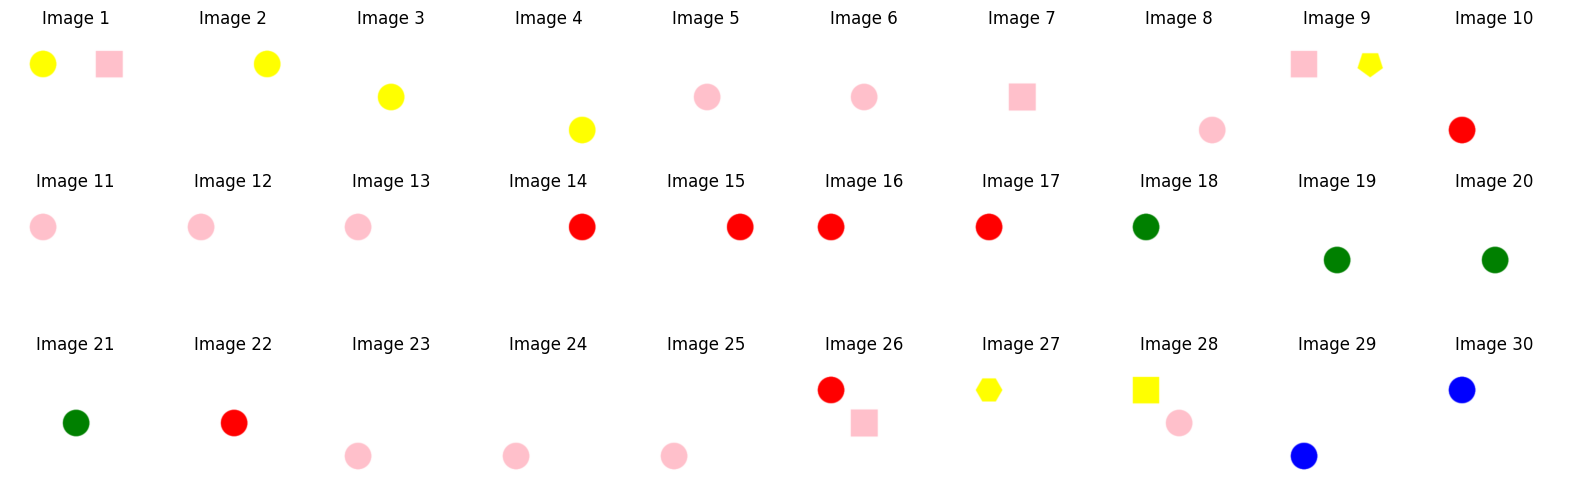

mean_18_432
[('circle', np.float64(0.8)), ('pink', np.float64(0.5666666666666667)), ('M', np.float64(0.4666666666666667)), ('TL', np.float64(0.3333333333333333)), ('red', np.float64(0.2))]
Neuron: mean_18_432


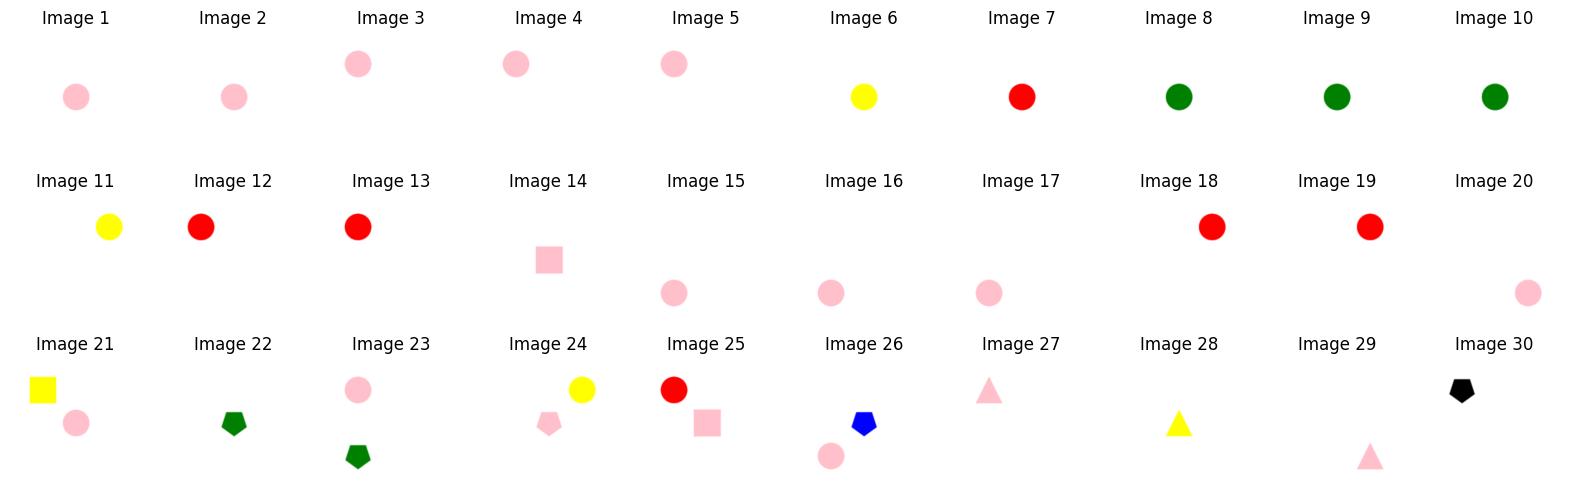

mean_18_7
[('circle', np.float64(0.6333333333333333)), ('pink', np.float64(0.5333333333333333)), ('M', np.float64(0.3)), ('TL', np.float64(0.3)), ('pentagon', np.float64(0.2))]
Neuron: mean_18_7


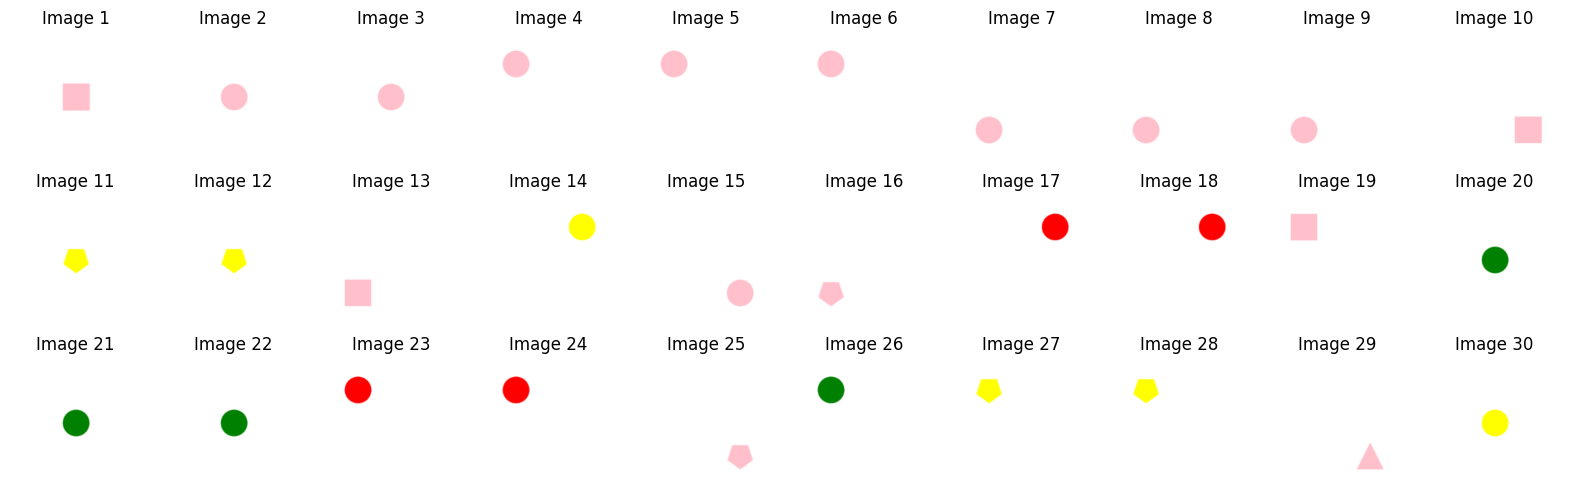

mean_17_949
[('pink', np.float64(0.6666666666666666)), ('circle', np.float64(0.5666666666666667)), ('TL', np.float64(0.3666666666666666)), ('yellow', np.float64(0.2666666666666666)), ('square', np.float64(0.2333333333333333))]
Neuron: mean_17_949


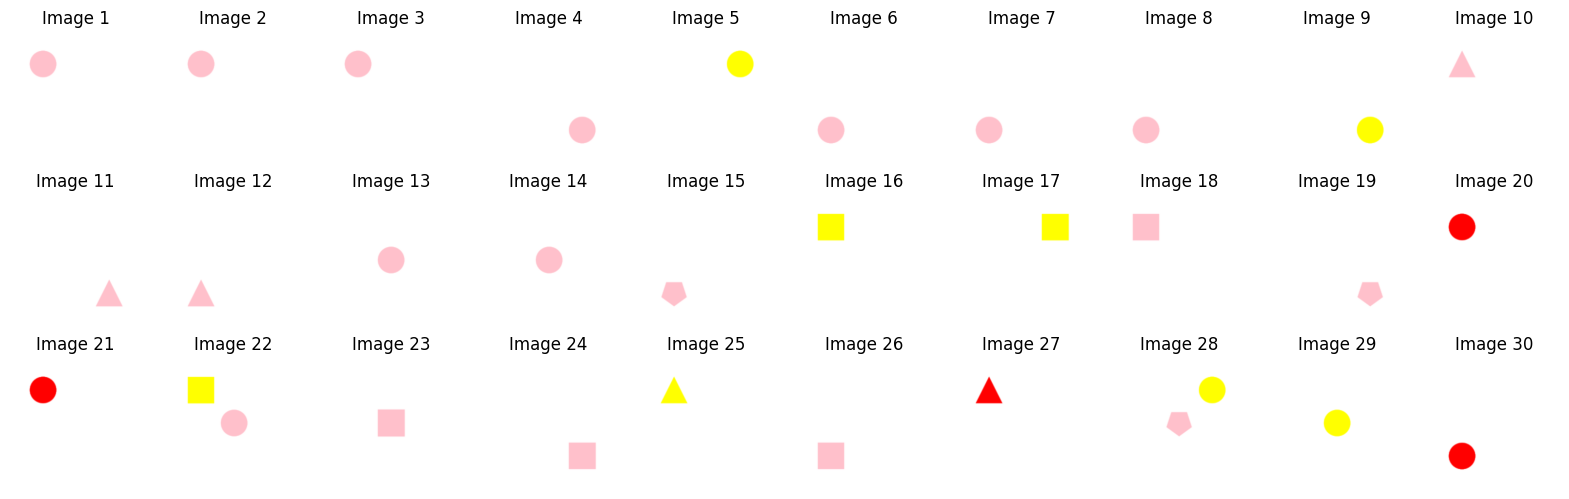

mean_18_223
[('pink', np.float64(0.5666666666666667)), ('circle', np.float64(0.5333333333333333)), ('TL', np.float64(0.3)), ('BL', np.float64(0.2666666666666666)), ('BR', np.float64(0.2333333333333333))]
Neuron: mean_18_223


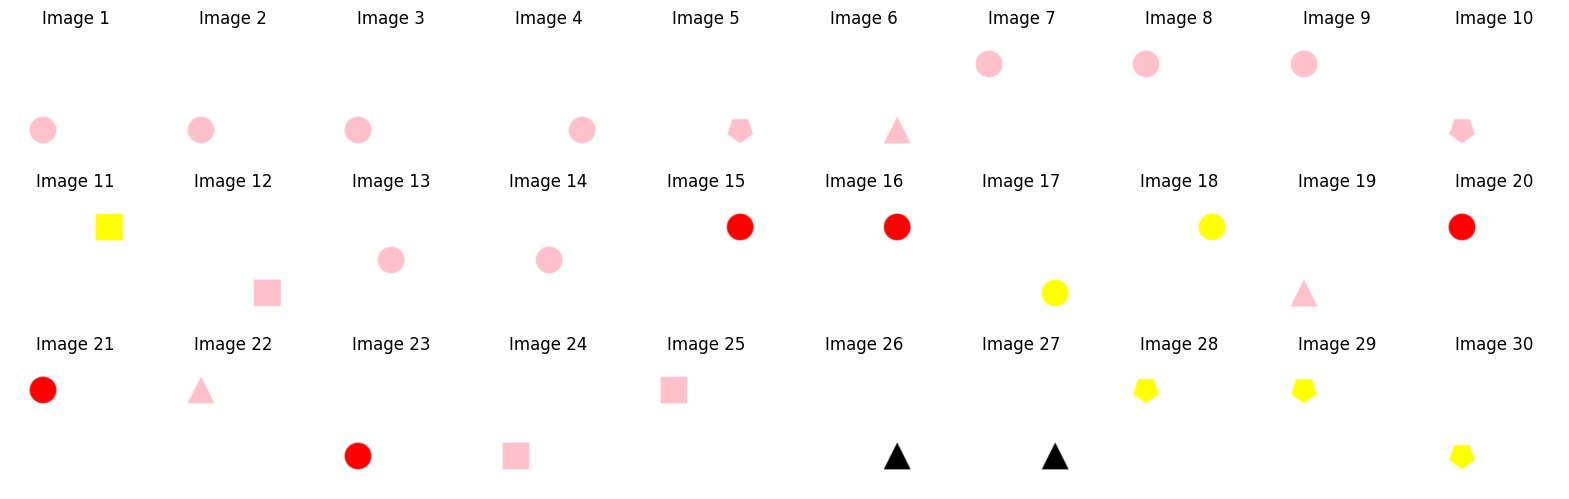

mean_14_991
[('circle', np.float64(0.7333333333333333)), ('M', np.float64(0.4666666666666667)), ('pink', np.float64(0.3666666666666666)), ('TL', np.float64(0.2666666666666666)), ('green', np.float64(0.2))]
Neuron: mean_14_991


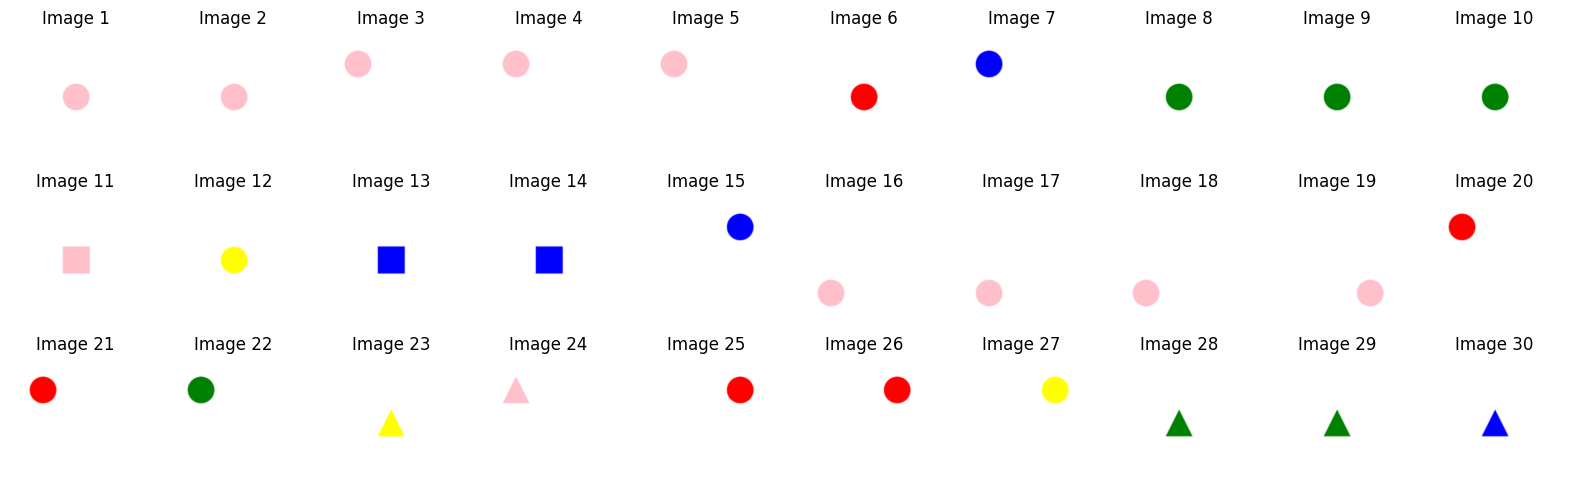

mean_18_21
[('circle', np.float64(0.6333333333333333)), ('M', np.float64(0.5)), ('pink', np.float64(0.4333333333333333)), ('red', np.float64(0.2)), ('TL', np.float64(0.2))]
Neuron: mean_18_21


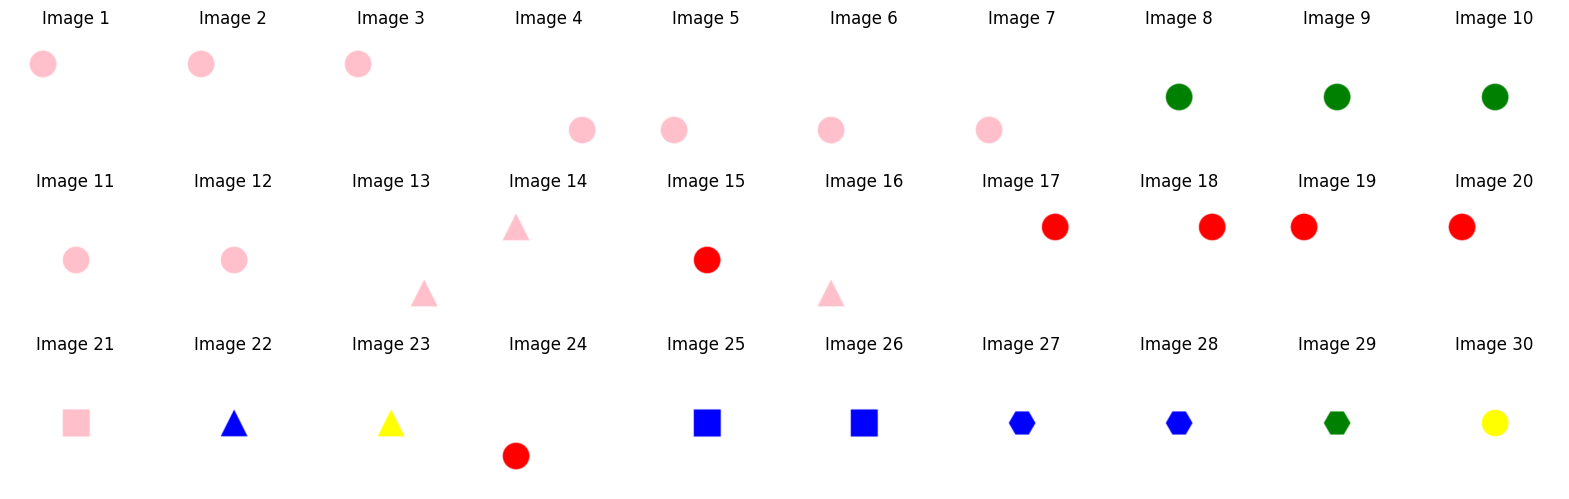

mean_15_210
[('pink', np.float64(0.8)), ('circle', np.float64(0.6333333333333333)), ('square', np.float64(0.5333333333333333)), ('BL', np.float64(0.4)), ('TL', np.float64(0.3333333333333333))]
Neuron: mean_15_210


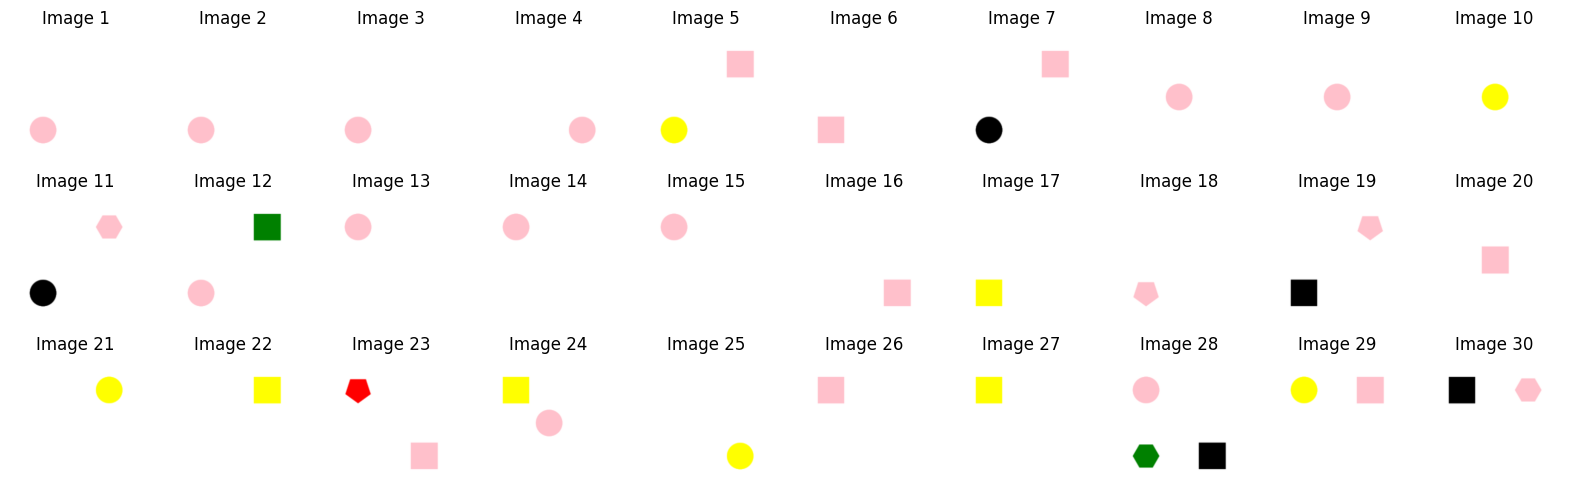

mean_16_165
[('circle', np.float64(0.9)), ('pink', np.float64(0.5666666666666667)), ('red', np.float64(0.4333333333333333)), ('square', np.float64(0.3666666666666666)), ('yellow', np.float64(0.3333333333333333))]
Neuron: mean_16_165


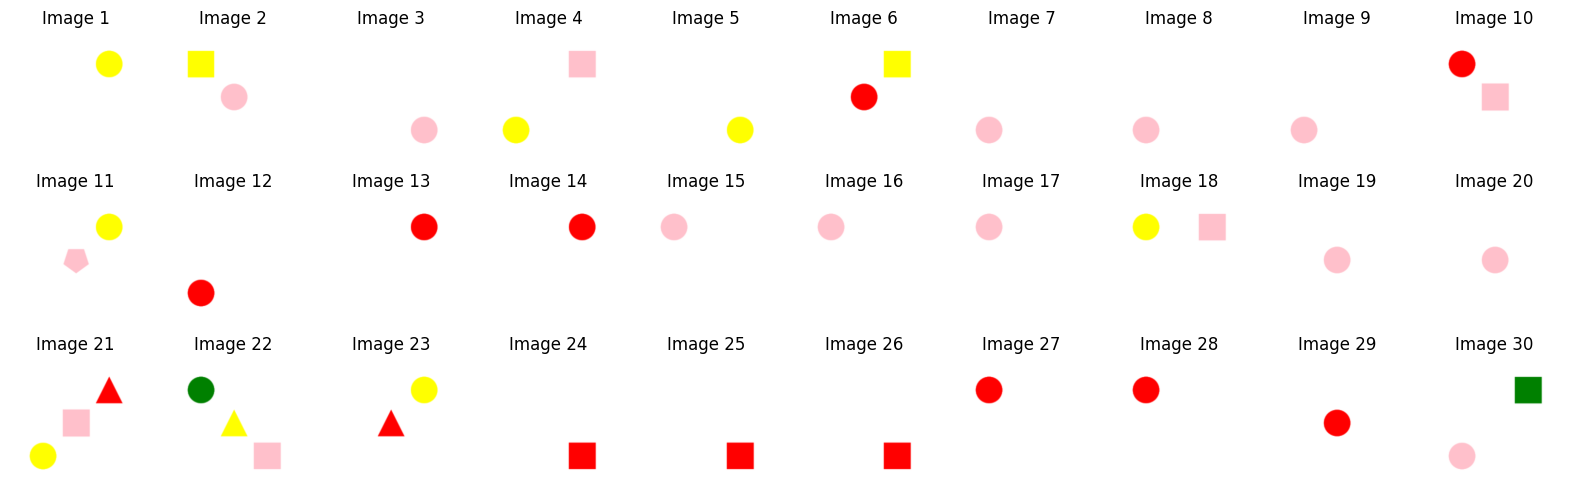

mean_16_557
[('circle', np.float64(0.6)), ('M', np.float64(0.5333333333333333)), ('pink', np.float64(0.5)), ('square', np.float64(0.3333333333333333)), ('yellow', np.float64(0.3333333333333333))]
Neuron: mean_16_557


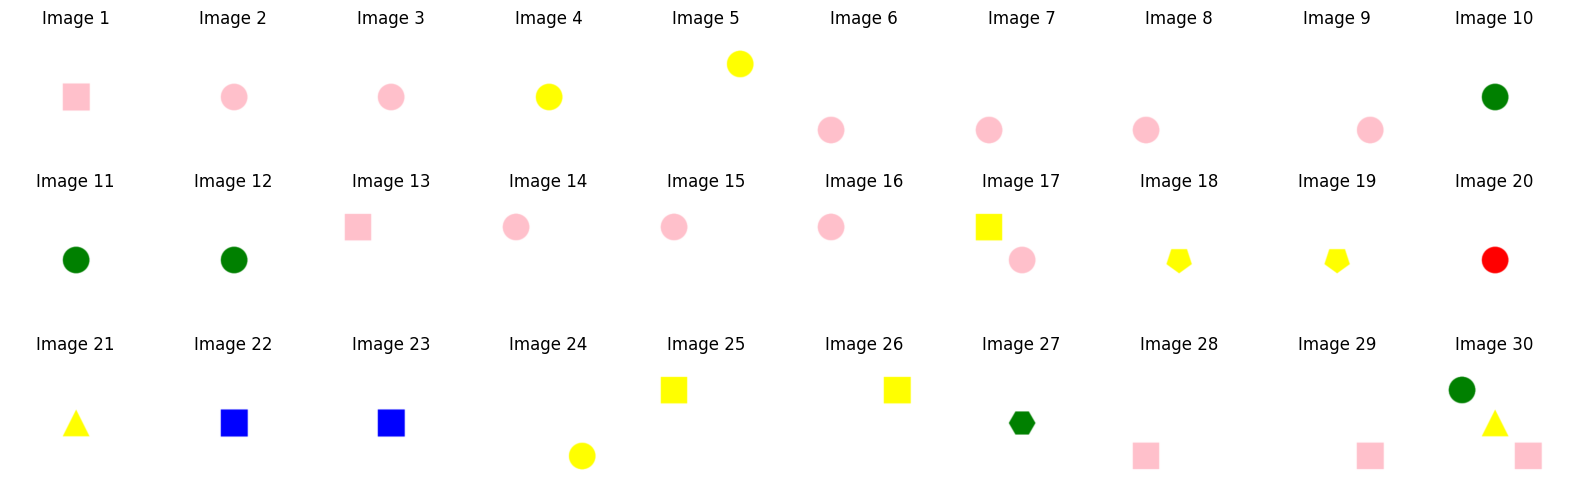

In [19]:
pair_chosen = ('avg_circle', 'avg_pink')

for neuron_name in pair_data[pair_chosen]['top_neurons'].sort_values('ratio', ascending=False).head(10)['neuron_name']:
    print(neuron_name)
    top_feats = get_top_features(low_entropy_neurons, neuron_name, top_k=5)

    print(top_feats)

    top_k = 30
    top_images = []

    activations = list(activations_df[neuron_name].items())
    activations.sort(key=lambda x: x[1], reverse=True)


    for i in range(top_k):
        row_idx = activations[i][0]
        image_path = activations_df.iloc[row_idx]['filename']
        top_images.append(image_path)


    # Plot the images in a row
    fig, axs = plt.subplots(top_k//10, 10, figsize=(20, 6))

    # write the top features of the neuron on the top of the plot
    

    axs = axs.flatten()
    print(f"Neuron: {neuron_name}")
    for i in range(top_k):
        image = Image.open(top_images[i])
        image = transform(image)
        axs[i].imshow(image.permute(1,2,0))
        axs[i].axis('off')
        axs[i].set_title(f"Image {i+1}")
    plt.show()